# Shapley Values from Scratch

## Set-up

In [1]:
from sklearn.ensemble import RandomForestRegressor
import shap
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
SEED = 0
plt.style.use("style.mplstyle")
shap.initjs()

## Load and Prepare Data

In [3]:
df = pd.read_csv("data.csv")
df.sample(10)

,crime rate,% residential zone,% industrial zone,Charles River,NOX concentration,number of rooms,% built before 1940,remoteness,connectedness,tax rate,pupil-teacher ratio,% working class,y
196,0.04011,80.0,1.52,0.0,0.404,7.287,34.1,7.3090,2.0,329.0,12.6,8.16,33300.0
212,0.21719,0.0,10.59,1.0,0.489,5.807,53.8,3.6526,4.0,277.0,18.6,32.06,22400.0
140,0.29090,0.0,21.89,0.0,0.624,6.174,93.6,1.6119,4.0,437.0,21.2,48.32,14000.0
168,2.30040,0.0,19.58,0.0,0.605,6.319,96.1,2.1000,5.0,403.0,14.7,22.20,23800.0
215,0.19802,0.0,10.59,0.0,0.489,6.182,42.4,3.9454,4.0,277.0,18.6,18.94,25000.0
176,0.07022,0.0,4.05,0.0,0.510,6.020,47.2,3.5549,5.0,296.0,16.6,20.22,23200.0
338,0.03306,0.0,5.19,0.0,0.515,6.059,37.3,4.8122,5.0,224.0,20.2,17.02,20600.0
253,0.36894,22.0,5.86,0.0,0.431,8.259,8.4,8.9067,7.0,330.0,19.1,7.08,42800.0
443,9.96654,0.0,18.10,0.0,0.740,6.485,100.0,1.9784,24.0,666.0,20.2,37.70,15400.0
314,0.36920,0.0,9.90,0.0,0.544,6.567,87.3,3.6023,4.0,304.0,18.4,18.56,23800.0


In [4]:
features = ["% working class", "number of rooms", "NOX concentration"]
y = df["y"].values
models = {}

## Train Models

In [5]:
# Model with no features
models["none"] = [y.mean()] * len(y)

In [6]:
# models with one feature
for feature in features:
    X = df[feature].values.reshape(-1, 1)
    m = RandomForestRegressor(random_state=SEED).fit(X, y)
    models[feature] = m.predict(X)

In [7]:
# models with two features
models_two = {}
for i, feature1 in enumerate(features):
    for feature2 in features[i+1:]:
        X = df[[feature1, feature2]].values
        m = RandomForestRegressor(random_state=SEED).fit(X, y)
        models[f"{feature1}, {feature2}"] = m.predict(X)

In [8]:
# model with all features
X_all = df[features]
m = RandomForestRegressor(random_state=SEED).fit(X_all, y)
models["all"] = m.predict(X_all)

## Calculate Shapley Values

In [9]:
sv_pwc = 1/3 * (models["% working class"] - models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - models["number of rooms"]) +\
         1/6 * (models["% working class, NOX concentration"] - models["NOX concentration"]) +\
         1/3 * (models["all"] - models["number of rooms, NOX concentration"])

sv_nor = 1/3 * (models["number of rooms"] - models["none"]) +\
         1/6 * (models["% working class, number of rooms"] - models["% working class"]) +\
         1/6 * (models["number of rooms, NOX concentration"] - models["NOX concentration"]) +\
         1/3 * (models["all"] - models["% working class, NOX concentration"])

sv_nc  = 1/3 * (models["NOX concentration"] - models["none"]) +\
         1/6 * (models["% working class, NOX concentration"] - models["% working class"]) +\
         1/6 * (models["number of rooms, NOX concentration"] - models["number of rooms"]) +\
         1/3 * (models["all"] - models["% working class, number of rooms"])

## Visualise Shapley Values

### Barplot of Mean Absolute Shapley Values

Mean absolute shapley values:
% working class  : 2,641.2
number of rooms  : 2,473.7
NOX concentration: 2,247.3


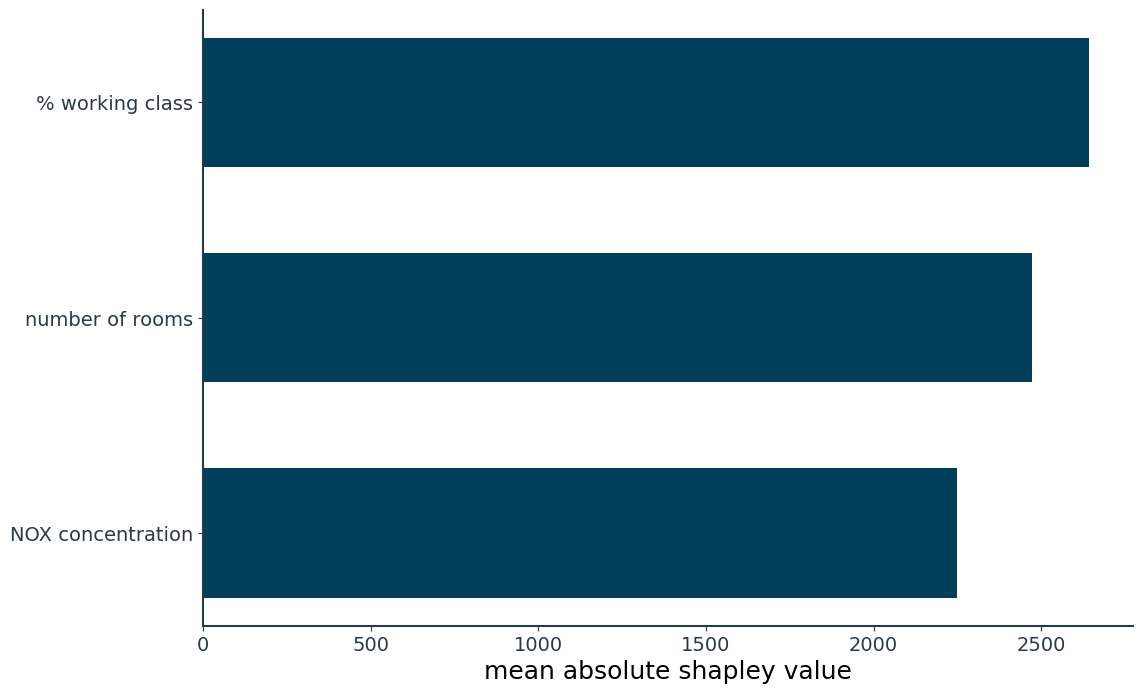

In [10]:
print("Mean absolute shapley values:")
print(f"% working class  : {np.abs(sv_pwc).mean():,.1f}")
print(f"number of rooms  : {np.abs(sv_nor).mean():,.1f}")
print(f"NOX concentration: {np.abs(sv_nc).mean():,.1f}")

fig, ax = plt.subplots()
ax.barh(
    ["NOX concentration", "number of rooms", "% working class"],
    [np.abs(sv_nc).mean(), np.abs(sv_nor).mean(), np.abs(sv_pwc).mean()],
    height=0.6
)
ax.set_xlabel("mean absolute shapley value");

### Beeswarm Plot of Shapley Values

In [11]:
df_sv = pd.DataFrame()
df_sv["feature"] = ["% working class"] * 506 + ["numer of rooms"] * 506 + ["NOX concentration"] * 506
df_sv["shapley value"] = np.concatenate([sv_pwc, sv_nor, sv_nc])
df_sv["hue"] = np.concatenate(
    [
        (df["% working class"].values - df["% working class"].mean()) / df["% working class"].std(),
        (df["number of rooms"].values - df["number of rooms"].mean()) / df["number of rooms"].std(),
        (df["NOX concentration"].values - df["NOX concentration"].mean()) / df["NOX concentration"].std(),
    ]
)
df_sv

,feature,shapley value,hue
0,% working class,2506.624884,-1.074499
1,% working class,-1106.837425,-0.491953
2,% working class,5458.020908,-1.207532
3,% working class,6562.725273,-1.360171
4,% working class,2932.269717,-1.025487
...,...,...,...
1513,NOX concentration,-1154.664410,0.157968
1514,NOX concentration,-1043.997743,0.157968
1515,NOX concentration,-1420.419965,0.157968
1516,NOX concentration,-1180.558457,0.157968


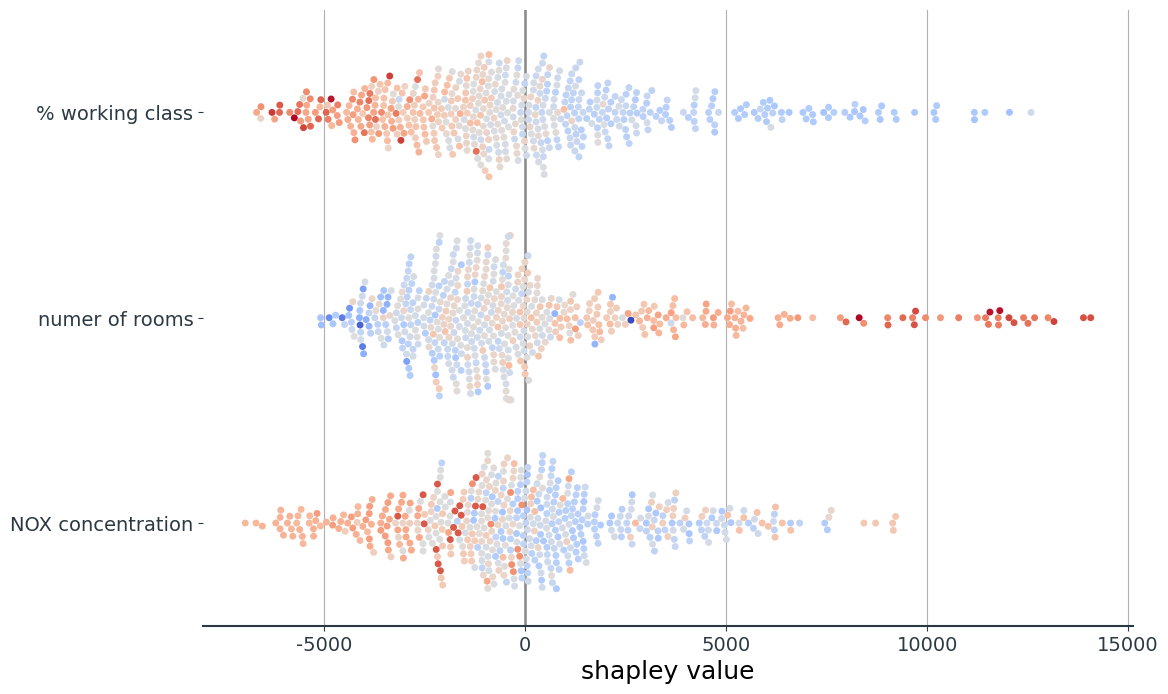

In [12]:
fig, ax = plt.subplots()
ax.axvline(0, c="grey", alpha=0.8)
ax = sns.swarmplot(
    x=df_sv["shapley value"],
    y=df_sv["feature"],
    hue=df_sv["hue"],
    palette="coolwarm",  # red = higher raw value; blue = lower raw value
    size=5,
    legend=False,
)
ax.spines.left.set_visible(False)
ax.grid(axis="x")
ax.set_ylabel("");